## Late Fusion

### Explanation of Late Fusion
- Combines the results of multiple systems after retrieval. Each system independently ranks items, and their scores/rankings are combined (e.g., weighted average, Borda count).
- Advantage: Preserves the unique characteristics of each retrieval system while combining their strengths.
- Challenge: Requires deciding on an effective method to combine scores and handle tie-breaking or normalization.

----

### Approach to Solving the Task

#### 1. **System Selection**:
   - Identify systems that complement each other:
     - **Different modalities**: For instance, combine a text-based model like `TF-IDF` (e.g., 74e55.json) with an audio-based model like `MFCC` (e.g., 88010.json).
     - **Different feature spaces**: Combine diverse embeddings like BERT (e.g., d3320.json) with CNN-based visual features like Inception (e.g., 18706.json).
   - Prefer models with high accuracy metrics and distinct diversity or popularity profiles.


In [23]:
import os
import json
from collections import defaultdict

# Directory containing the JSON files
input_dir = '../public/data/precomputed_systems'

# Function to load recommendations from a JSON file
def load_recommendations(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
        return data.get('content', {})

# Function to load metadata from a JSON file
def load_metadata(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
        return data.get('metadata', {}).get('feature_space', 'unknown')

# Dictionary to hold recommendations and metadata with filenames as keys
recommendations_dict = {}
metadata_dict = {}

# Iterate over all files in the input directory
for filename in os.listdir(input_dir):
    file_path = os.path.join(input_dir, filename)
    if filename.endswith('.json') and filename != 'metadata_by_file.json':
        recommendations = load_recommendations(file_path)
        feature_space = load_metadata(file_path)
        recommendations_dict[feature_space] = recommendations
        metadata_dict[filename] = feature_space

# Calculate overlap of retrieved songs between different feature spaces
overlap_dict = defaultdict(dict)

for space1, recs1 in recommendations_dict.items():
    for space2, recs2 in recommendations_dict.items():
        if space1 != space2:
            overlap_count = 0
            total_count = 0
            for song_id, recs1_list in recs1.items():
                recs2_list = recs2.get(song_id, [])
                overlap_count += len(set(recs1_list) & set(recs2_list))
                total_count += len(set(recs1_list) | set(recs2_list))
            overlap_dict[space1][space2] = overlap_count / total_count if total_count > 0 else 0

# Display the overlap results
for space1, overlaps in overlap_dict.items():
    print(f"Overlap for {space1}:")
    for space2, overlap in overlaps.items():
        print(f"  with {space2}: {overlap:.4f}")

Overlap for Inception:
  with Spectral: 0.0127
  with VGG19: 0.2846
  with Random: 0.0098
  with TF-IDF: 0.0108
  with MFCC: 0.0128
  with BERT: 0.0127
Overlap for Spectral:
  with Inception: 0.0127
  with VGG19: 0.0127
  with Random: 0.0098
  with TF-IDF: 0.0116
  with MFCC: 0.0257
  with BERT: 0.0144
Overlap for VGG19:
  with Inception: 0.2846
  with Spectral: 0.0127
  with Random: 0.0098
  with TF-IDF: 0.0110
  with MFCC: 0.0125
  with BERT: 0.0129
Overlap for Random:
  with Inception: 0.0098
  with Spectral: 0.0098
  with VGG19: 0.0098
  with TF-IDF: 0.0098
  with MFCC: 0.0099
  with BERT: 0.0099
Overlap for TF-IDF:
  with Inception: 0.0108
  with Spectral: 0.0116
  with VGG19: 0.0110
  with Random: 0.0098
  with MFCC: 0.0119
  with BERT: 0.0528
Overlap for MFCC:
  with Inception: 0.0128
  with Spectral: 0.0257
  with VGG19: 0.0125
  with Random: 0.0099
  with TF-IDF: 0.0119
  with BERT: 0.0152
Overlap for BERT:
  with Inception: 0.0127
  with Spectral: 0.0144
  with VGG19: 0.0129


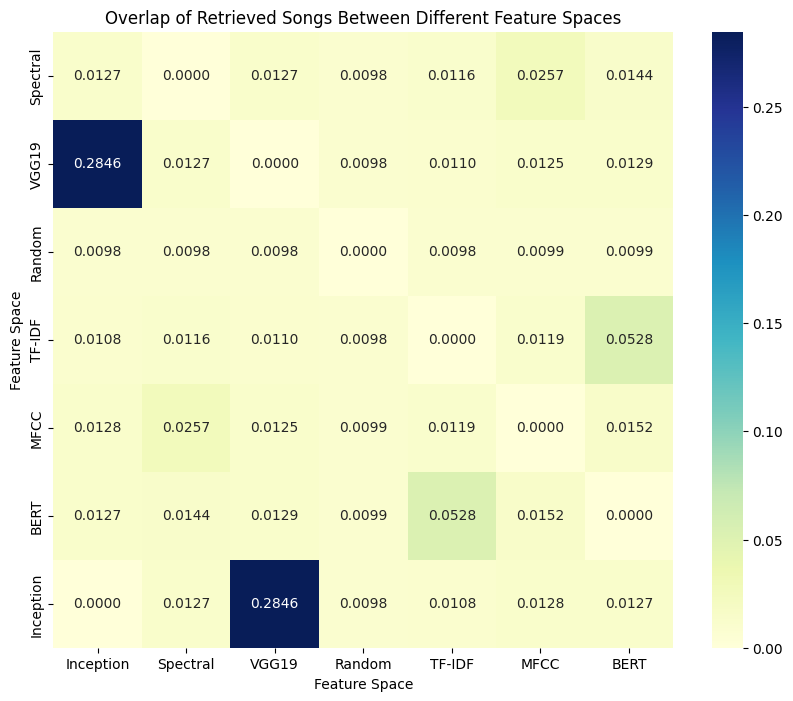

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert overlap_dict to a DataFrame for easier plotting
overlap_df = pd.DataFrame(overlap_dict).fillna(0)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(overlap_df, annot=True, cmap="YlGnBu", fmt=".4f")
plt.title("Overlap of Retrieved Songs Between Different Feature Spaces")
plt.xlabel("Feature Space")
plt.ylabel("Feature Space")
plt.show()


In [1]:
import pandas as pd
import os
import json

# Load the data from the JSON file
with open('../public/data/precomputed_systems/metadata_by_file.json', 'r') as file:
    data = json.load(file)
    tfidf_vgg19_systems = {k: v for k, v in data.items() if v['feature_space'] in ['TF-IDF', 'VGG19'] and v['similarity_metric'] == 'cosine'}
    # Convert the dictionary to a DataFrame for better visualization
    df_tfidf_vgg19 = pd.DataFrame.from_dict(tfidf_vgg19_systems, orient='index').sort_values(by='feature_space')
df_tfidf_vgg19

,feature_space,N,similarity_metric,Precision@N,Recall@N,NDCG@N,MRR,Div@N,AvgPop@N
74e55.json,TF-IDF,100,cosine,0.599023,0.023009,0.824755,0.743353,0.054782,0.408643
5b3de.json,VGG19,100,cosine,0.607673,0.022306,0.825145,0.773699,0.054590,0.420798


For a faster computation we'll recalculate these systems for only 1000 samples:

In [2]:
# Directory containing the JSON files
directory = '../public/data/late_fusion'

# Initialize an empty list to store the systems
systems_list = []

# Iterate through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.json') and filename != 'late_fusion.json':
        with open(os.path.join(directory, filename), 'r') as file:
            system = json.load(file)
            systems_list.append(system)

print(f'Loaded {len(systems_list)} systems.')

# Convert the list of systems to a DataFrame for better visualization
systems_metadata_df = pd.DataFrame([system['metadata'] for system in systems_list])
systems_metadata_df


Loaded 2 systems.


,feature_space,N,similarity_metric,Precision@N,Recall@N,NDCG@N,MRR,Div@N,AvgPop@N
0,VGG19,100,cosine,0.56618,0.106720,0.805449,0.733746,0.543451,0.444478
1,TF-IDF,100,cosine,0.55895,0.108889,0.806368,0.729003,0.560618,0.418170


#### 2. **Implementation**:
   - Use normalized scores or rankings from individual systems.
   - Combine rankings through weighted averaging, voting, or another scoring strategy.

In [3]:
import json
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load retrieval results from systems_list
tfidf_results = next(system for system in systems_list if system['metadata']['feature_space'] == 'TF-IDF')
tfidf_scores = tfidf_results['content']
vgg19_results = next(system for system in systems_list if system['metadata']['feature_space'] == 'VGG19')
vgg19_content = vgg19_results['content']

# Normalize scores for both systems
def normalize_scores(system_results):
    scaler = MinMaxScaler()
    for query, doc_scores in system_results.items():
        scores = list(doc_scores.values())
        normalized_scores = scaler.fit_transform(np.array(scores).reshape(-1, 1)).flatten()
        system_results[query] = dict(zip(doc_scores.keys(), normalized_scores))
    return system_results

normalized_tfidf_scores = normalize_scores(tfidf_scores)
normalized_vgg19_content = normalize_scores(vgg19_content)

# Late Fusion: Weighted Sum
def fuse_results(system1, system2, weight1=0.5, weight2=0.5):
    fused_results = defaultdict(dict)
    all_queries = set(system1.keys()).union(set(system2.keys()))
    
    for query in all_queries:
        all_docs = set(system1.get(query, {}).keys()).union(set(system2.get(query, {}).keys()))
        for doc in all_docs:
            score1 = system1.get(query, {}).get(doc, 0)
            score2 = system2.get(query, {}).get(doc, 0)
            fused_score = weight1 * score1 + weight2 * score2
            fused_results[query][doc] = fused_score
        # Sort the results by score
        fused_results[query] = dict(sorted(fused_results[query].items(), key=lambda x: x[1], reverse=True))
    return fused_results

fused_results = fuse_results(normalized_tfidf_scores, normalized_vgg19_content, weight1=0.6, weight2=0.4)

# Save fused results with metadata
fused_results_with_metadata = {
    'metadata': {
        'tfidf': tfidf_results['metadata'],
        'vgg19': vgg19_results['metadata']
    },
    'fused_content': fused_results
}

output_directory = "../public/data/late_fusion"
output_file_path = os.path.join(output_directory, "late_fusion.json")
with open(output_file_path, "w") as f:
    json.dump(fused_results_with_metadata, f, indent=4)

# Print the first few entries of the fused results
for key in list(fused_results_with_metadata['fused_content'].keys())[:5]:
    print(f"{key}: {fused_results_with_metadata['fused_content'][key]}")

9UFC7eAzSaMCtTsP: {'1KYWPzVvo2COw53Y': 0.6000000000000001, '7PFbEi2D2e00Pmzo': 0.4, '1D1TsRmNu7OYSnlG': 0.3721585029741736, '97qvpPek95TfoIpa': 0.35507039513829003, 'AOj9VAtNbKtbGyDM': 0.3544641025208307, '4NyMsdTfS1vA1Nsz': 0.3464963196990031, '0tzYEg8KodbJHl8p': 0.30424236072190214, '7woX9FySIDxg1IGV': 0.2774339920594403, '1nluAgAtCW9YJOn5': 0.25129967429313993, 'BkEiMHPrYdbWkAW0': 0.24915062118505119, '2K1SfANKQR6RJHNN': 0.24820585881535778, 'ASmQDQZeVJytIHp4': 0.24543819430319438, '8qsKHsA7akNyFo0N': 0.24268296193427866, '9ooJKeuvH1TEi4nV': 0.24154729855159474, 'Bz8Ut1ZVZhWnvoMo': 0.22972085017996768, 'Ap2jNYMNObvQLO34': 0.22514950806450892, '10E4iAVRq4bJcMBe': 0.2207582263652971, '3HDWcbqiTkira9kn': 0.21652757408332193, '1cKGmPvdSdGq8jg9': 0.21597686882362802, '0OuXKk7qlgvo6egK': 0.2025357081923196, '5dDcdJt07q8BObYg': 0.2006505255098553, 'BEgdPDmHrqCmyoVY': 0.19780150089842508, '2YMhCsXXNlDpuuGU': 0.19681238947328233, 'A93SWqSFGpZYuYWi': 0.18610017167117596, '40c5Um2HSf3T38fi': 0

#### 3. **Evaluation**:
   - Use the following metrics for comparison:
     - **Accuracy metrics**: Precision@N, Recall@N, NDCG@N, and MRR.
     - **Beyond-accuracy metrics**: Diversity (Div@N), Retrievability (Cov@N), and Popularity (AvgPop@N).
   - Compare the late fusion system against the individual systems to highlight improvements or trade-offs.

##### Load data

In [4]:
# Applied when value bigger than 0 is specified
DATASET_LENGTH_LIMIT = 1000

In [5]:
# Load the dataset
from scripts.utils import load_dataset_with_info

dataset = load_dataset_with_info()

if DATASET_LENGTH_LIMIT > 0:
    dataset = dataset.head(DATASET_LENGTH_LIMIT)

print(f"Shape: {dataset.shape}")
dataset.head(2)

Shape: (1000, 18)


,id,genre,artist,song,album_name,spotify_id,popularity,release,danceability,energy,song_key,mode,valence,tempo,duration_ms,"(tag, weight)",total_listens,url
0,01rMxQv6vhyE1oQX,"[rock, pop punk]",Against the Current,Chasing Ghosts,In Our Bones,4UYpnpm7ZDdo0hyyZNXSpl,41.0,2016,0.598,0.722,6.0,0.0,0.382,104.001,209507,"{'rock': 100, 'alternative': 100, 'pop punk': ...",1491,https://www.youtube.com/watch?v=f7dx1GgO7CI
1,02ZnlCGZEbkfCDxo,"[pop, italian pop, latin, europop, ambient, po...",Laura Pausini,Tra Te E Il Mare,The Best of Laura Pausini - E Ritorno Da Te,7eiFkQw3snYtC8jtHNUWvf,36.0,2001,0.569,0.727,1.0,0.0,0.225,110.964,228840,"{'italian': 100, 'laura pausini': 91, 'pop': 6...",2655,https://www.youtube.com/watch?v=4n6NSFvV6C0


In [6]:
# Load the merged_tfidf_dataset, tfidf_columns
from scripts.utils import load_and_merge_tfidf_data

tfidf_embeddings_path = "../dataset/id_lyrics_tf-idf_mmsr.tsv"
merged_tfidf_dataset, tfidf_columns = load_and_merge_tfidf_data(dataset, tfidf_embeddings_path)
print(f"Shape: {merged_tfidf_dataset.shape}")

Shape: (1000, 1017)


In [7]:
# Load visual merged_visual_dataset_vgg19, vgg19_columns
vgg19_path = "../dataset/id_vgg19_mmsr.tsv"
vgg19_data = pd.read_csv(vgg19_path, sep='\t')
vgg19_columns = vgg19_data.columns[1:]  # Exclude 'id'
merged_visual_dataset_vgg19 = pd.merge(dataset, vgg19_data, on='id')
print(f"Shape: {merged_visual_dataset_vgg19.shape}")

Shape: (1000, 8210)


In [18]:
# Normalize values in tfidf_columns of merged_tfidf_dataset
scaler_tfidf = MinMaxScaler()
merged_tfidf_dataset[tfidf_columns] = scaler_tfidf.fit_transform(merged_tfidf_dataset[tfidf_columns])

# Normalize values in vgg19_columns of vgg19_data
scaler_vgg19 = MinMaxScaler()
vgg19_data[vgg19_columns] = scaler_vgg19.fit_transform(vgg19_data[vgg19_columns])

# Load visual TF_IDF_VGG19_dataset, TF_IDF_VGG19_columns
TF_IDF_VGG19_columns = list(tfidf_columns) + list(vgg19_columns)
TF_IDF_VGG19_dataset = pd.merge(merged_tfidf_dataset, vgg19_data, on='id')
print(f"Shape: {TF_IDF_VGG19_dataset.shape}")

Shape: (1000, 9210)


##### Evaluate

In [19]:
# Define datasets and feature columns for each system
from scripts.tradeoff_evaluation import evaluate_tradeoffs
import random

N_tradeoff = 10
num_samples = 100
random.seed(42)
query_indices = random.sample(range(len(dataset)), num_samples)


systems = {
    "Random": None,
    "VGG19": vgg19_columns,
    "TF_IDF_VGG19": TF_IDF_VGG19_columns,
    "TF-IDF": tfidf_columns,
}
datasets = {
    "Random": dataset,
    "VGG19": merged_visual_dataset_vgg19,
    "TF_IDF_VGG19": TF_IDF_VGG19_dataset,
    "TF-IDF": merged_tfidf_dataset,
}

beyond_metrics = ["cosine"]
tradeoff_results = evaluate_tradeoffs(
    query_indices,
    datasets,
    systems,
    beyond_metrics,
    beyond_tags_column="(tag, weight)",
    beyond_popularity_column="popularity",
    N=N_tradeoff,
)

print("\nTrade-Off Results:")
print(tradeoff_results)

Random:


Processing queries for Random Baseline: 100%|██████████| 100/100 [00:00<00:00, 711.75it/s]



VGG19:


Processing queries for cosine metric: 100%|██████████| 100/100 [00:08<00:00, 11.51it/s]



TF_IDF_VGG19:


Processing queries for cosine metric: 100%|██████████| 100/100 [00:11<00:00,  8.95it/s]



TF-IDF:


Processing queries for cosine metric: 100%|██████████| 100/100 [00:06<00:00, 15.60it/s]



Trade-Off Results:
         System  Metric  Precision@N  Recall@N    NDCG@N     Div@N  AvgPop@N
0        Random  random        0.571  0.011521  0.755084  0.032027  0.486432
1         VGG19  cosine        0.557  0.013173  0.745511  0.024669  0.427705
2  TF_IDF_VGG19  cosine        0.563  0.013161  0.748277  0.025050  0.429875
3        TF-IDF  cosine        0.538  0.010922  0.731311  0.023984  0.415091


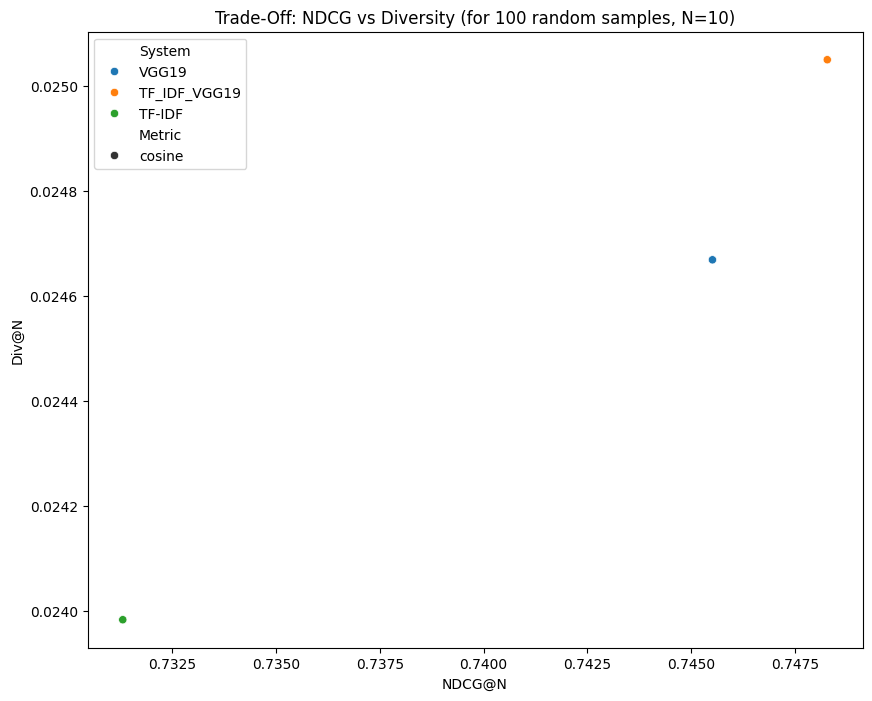

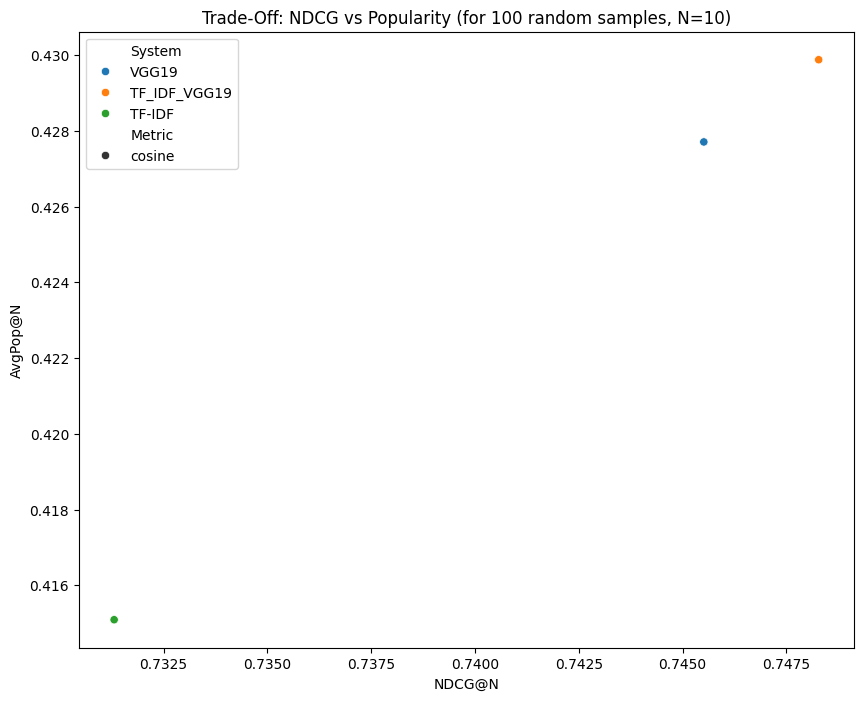

In [22]:
# Optionally, plot the trade-offs
import matplotlib.pyplot as plt
import seaborn as sns

# Drop the "Random" system from tradeoff_results
filtered_tradeoff_results = tradeoff_results[tradeoff_results['System'] != 'Random']

fig, ax = plt.subplots(figsize=(10, 8))

# Plot NDCG vs Diversity
sns.scatterplot(data=filtered_tradeoff_results, x=f'NDCG@N', y=f'Div@N', hue='System', style='Metric')
plt.title(f'Trade-Off: NDCG vs Diversity (for {num_samples} random samples, N={N_tradeoff})')
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
# Plot NDCG vs Popularity
sns.scatterplot(data=filtered_tradeoff_results, x=f'NDCG@N', y=f'AvgPop@N', hue='System', style='Metric')
plt.title(f'Trade-Off: NDCG vs Popularity (for {num_samples} random samples, N={N_tradeoff})')
plt.show()

4. **Design Trade-offs**:
   - Optimize diversity and accuracy using parameters that control the influence of each metric (e.g., adjusting weights in late fusion).
   - Consider the trade-off between computational complexity (early fusion) and implementation flexibility (late fusion).

---

### Evaluation Plan

1. **Quantitative Analysis**:
   - Compute all accuracy and beyond-accuracy metrics for the two hybrid systems and the individual systems.
   - Use statistical tests (e.g., paired t-tests) to confirm whether performance differences are significant.

2. **Qualitative Analysis**:
   - Examine retrieval lists for various queries.
   - Analyze how different fusion strategies influence the nature of retrieved results (e.g., diversity, genre coverage).

3. **Final Comparison**:
   - Create a comparative visualization (e.g., bar charts, heatmaps) of metric scores across all systems.

---